In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.ref_book import ReferenceBookAnonymization

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на обезличенном датасете i2b2 2014 без учёта регистра

### Этап 2: Демонстрация результатов на наборе данных i2b2 2006
Демонстрация включает в себя измерение метрик Recall, Precision и $F_1$ score для следующий моделей:
* BERT-base-cased
* BERT-base-uncased
* BERT-large-cased
* BERT-large-uncased

#### BERT-base-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

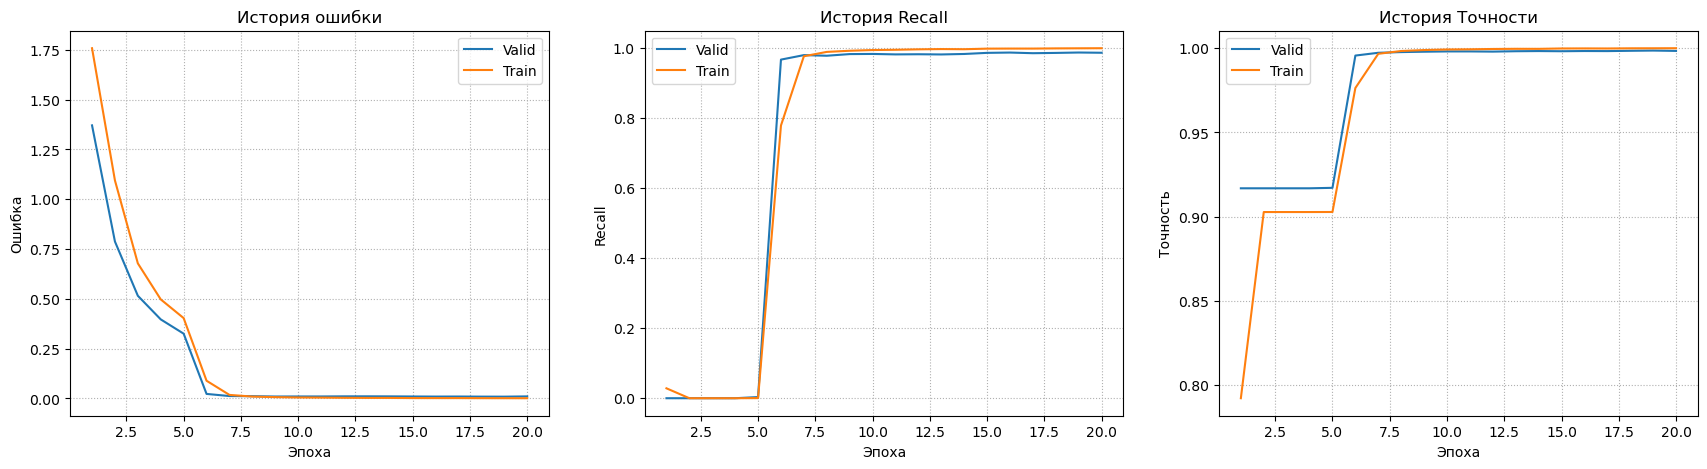

In [7]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(0)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [8]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2006_data_config['val_data_type'],
                               path_to_folder=i2b2_2006_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-base-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(0)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [10]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9985151290893555
     test_precision         0.9985151290893555
       test_recall          0.9872044920921326
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9872044920921326,
  'test_precision': 0.9985151290893555,
  'test_f1': 0.9985151290893555}]

              precision    recall  f1-score   support

        NAME     0.9904    0.9923    0.9914     14290
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.9817    0.9549    0.9681      6358
         AGE     0.6364    0.5833    0.6087        12
        DATE     0.9953    0.9946    0.9950      8169
          ID     0.9937    0.9984    0.9960      6809
     CONTACT     0.9948    0.9885    0.9917       781

   micro avg     0.9907    0.9872    0.9889     36419
   macro avg     0.7989    0.7874    0.7930     36419
weighted avg     0.9906    0.9872    0.9889     36419



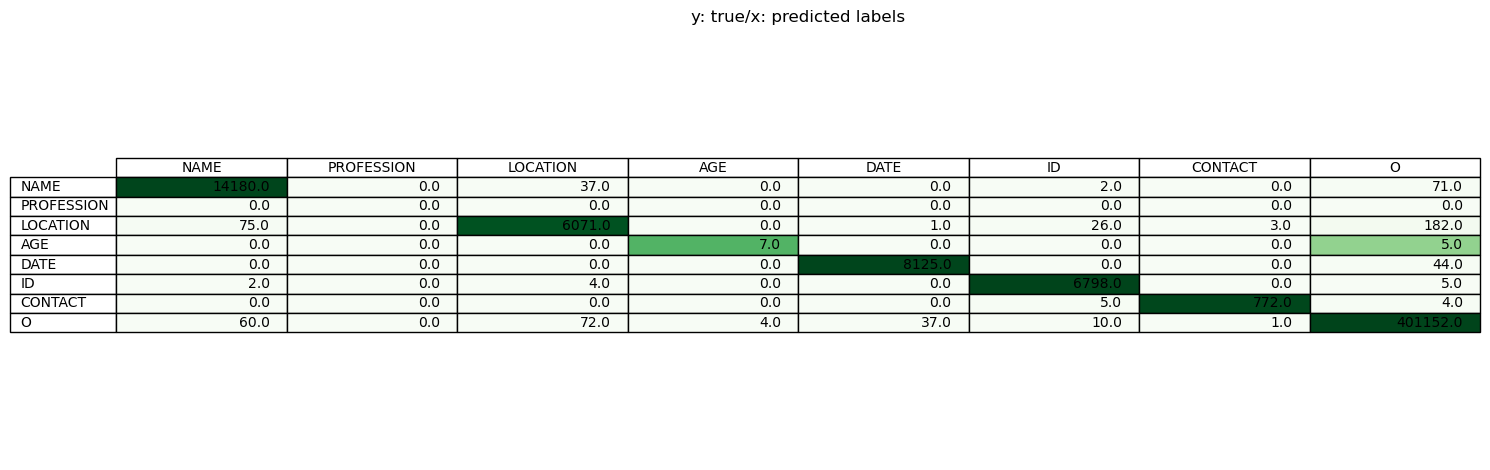

Wrongly predicted examples:
_____ Record 570:-6 _____
| Sentence:    | . | She | remained | afebrile | and | was | able | to | be | transferred | to | rehabilitation | on | 10   | /    | 7    | / | 93 | or | 10   | /    | 8    | / | 93 | , | without | difficulties | . | DISCHARGE | DIAGNOSIS | : | coronary | artery | disease | SPECIAL | PROCEDURES | AND | OPERATIONS | : | 9    | /    | 29   | / | 93 | , | coronary | artery | bypass | grafting | and | repair | of | false | femoral | aneurysm | . | # | 2 | . | cardiac | catheterization | 9    |
| True labels: | O | O   | O        | O        | O   | O   | O    | O  | O  | O           | O  | O              | O  | DATE | DATE | DATE | O | O  | O  | DATE | DATE | DATE | O | O  | O | O       | O            | O | O         | O         | O | O        | O      | O       | O       | O          | O   | O          | O | DATE | DATE | DATE | O | O  | O | O        | O      | O      | O        | O   | O      | O  | O     | O       | O        | O | O |

In [11]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-base-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

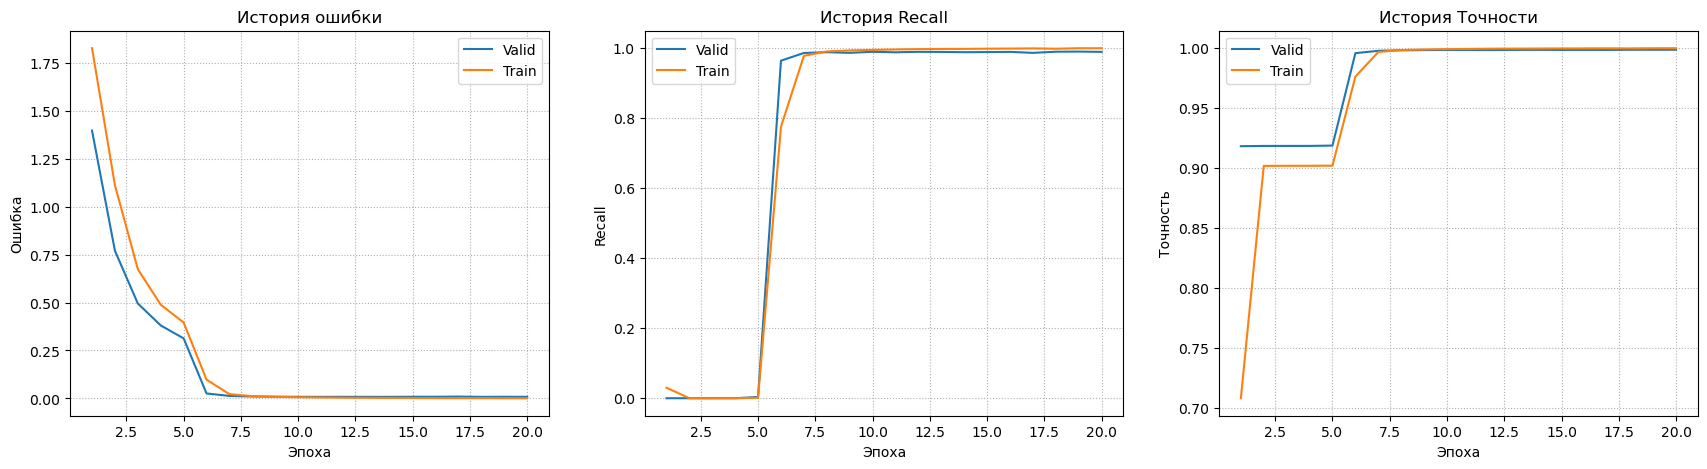

In [12]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(1)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [13]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2006_data_config['val_data_type'],
                               path_to_folder=i2b2_2006_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [14]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(1)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [15]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9986026883125305
     test_precision         0.9986026883125305
       test_recall          0.9895279407501221
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9895279407501221,
  'test_precision': 0.9986026883125305,
  'test_f1': 0.9986026883125305}]

              precision    recall  f1-score   support

        NAME     0.9905    0.9930    0.9917     10501
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.9832    0.9617    0.9723      5534
         AGE     0.5714    0.8000    0.6667        10
        DATE     0.9911    0.9983    0.9947      7821
          ID     0.9947    0.9970    0.9959      6264
     CONTACT     0.9930    0.9958    0.9944       714

   micro avg     0.9901    0.9895    0.9898     30844
   macro avg     0.7891    0.8208    0.8022     30844
weighted avg     0.9901    0.9895    0.9898     30844



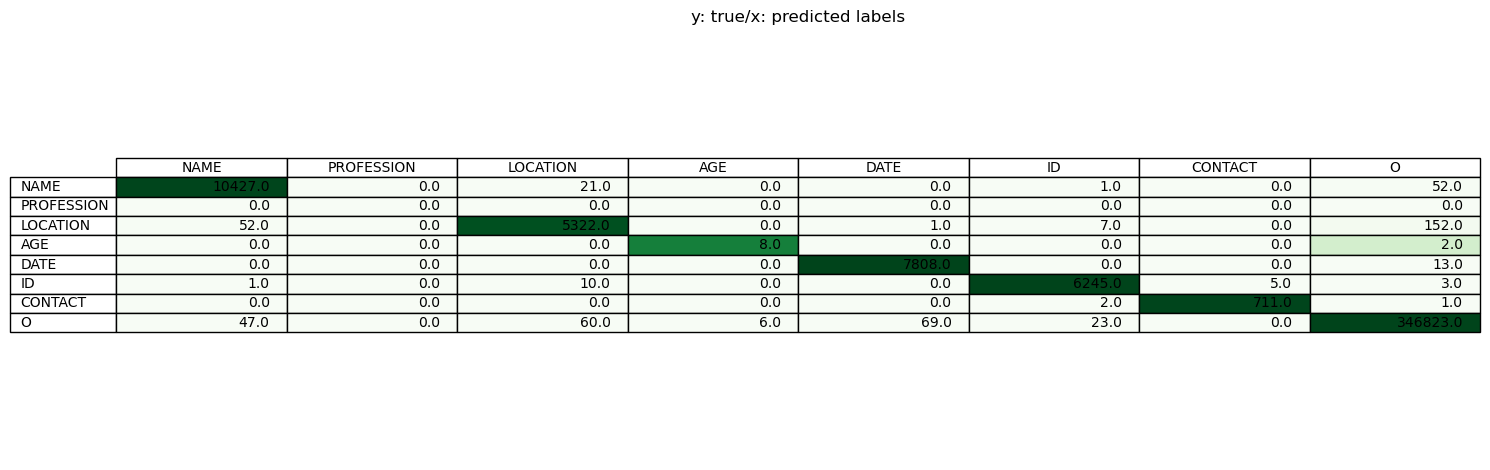

Wrongly predicted examples:
_____ Record 613:-28 _____
| Sentence:    | 03 | admission | date | : | 08   | /    | 15   | / | 1998 | discharge | date | : | 08   | /    | 22   | / | 1998 | principal | diagnosis | : | coronary | artery | disease | . | associated | diagnosis | : | failed | coronary | artery | bypass | graft | , | prior | myocardial | infarction | , | hypertension | , | elevated | cholesterol | , | renal | insufficiency | , | congestive | heart | failure | . | principal | procedure | : | 08   | /    | 20   | / | 98 | dual | chamber | pacemaker | generator | change | ( | cpi | 1276 | meridian | dr | ) | . | associated | procedures | : | 08   | /    | 15   | / | 98 | bilateral | heart | catheterization |
| True labels: | ID | O         | O    | O | DATE | DATE | DATE | O | O    | O         | O    | O | DATE | DATE | DATE | O | O    | O         | O         | O | O        | O      | O       | O | O          | O         | O | O      | O        | O      | O      | O     | O | O  

In [16]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

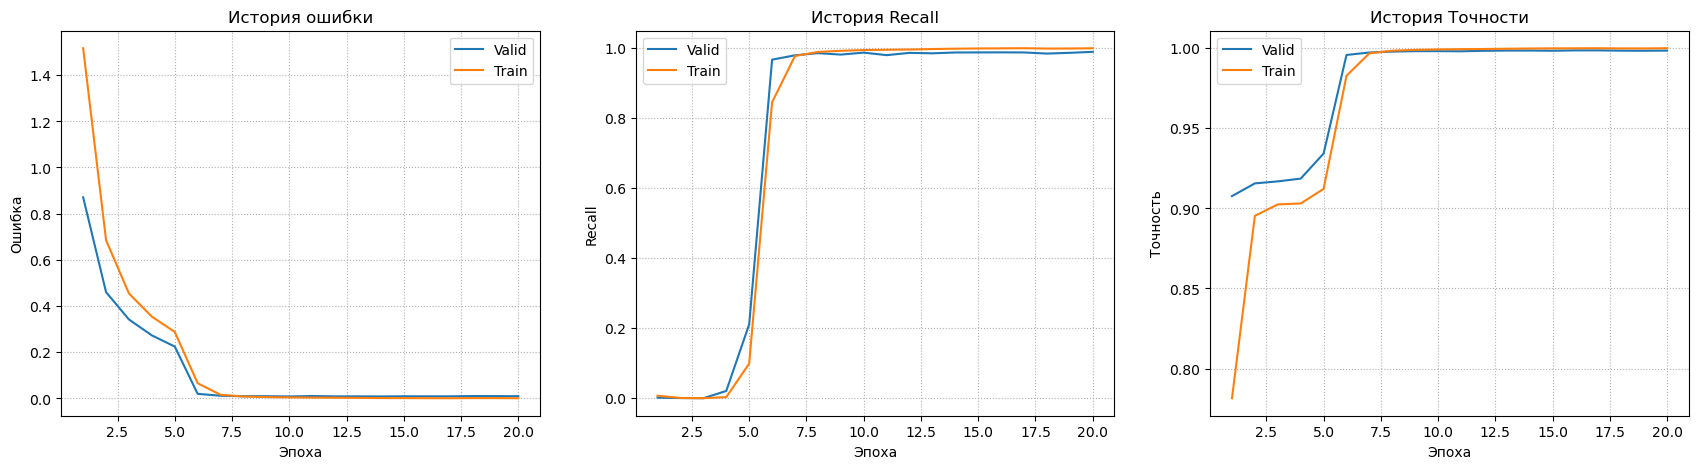

In [17]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(0)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [18]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2006_data_config['val_data_type'],
                               path_to_folder=i2b2_2006_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-large-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


In [19]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(0)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [20]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9983918070793152
     test_precision         0.9983918070793152
       test_recall          0.9887970685958862
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9887970685958862,
  'test_precision': 0.9983918070793152,
  'test_f1': 0.9983918070793152}]

              precision    recall  f1-score   support

        NAME     0.9848    0.9951    0.9899     14290
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.9784    0.9547    0.9664      6358
         AGE     0.6875    0.9167    0.7857        12
        DATE     0.9911    0.9964    0.9938      8169
          ID     0.9920    0.9984    0.9952      6809
     CONTACT     0.9961    0.9885    0.9923       781

   micro avg     0.9866    0.9888    0.9877     36419
   macro avg     0.8043    0.8357    0.8176     36419
weighted avg     0.9866    0.9888    0.9876     36419



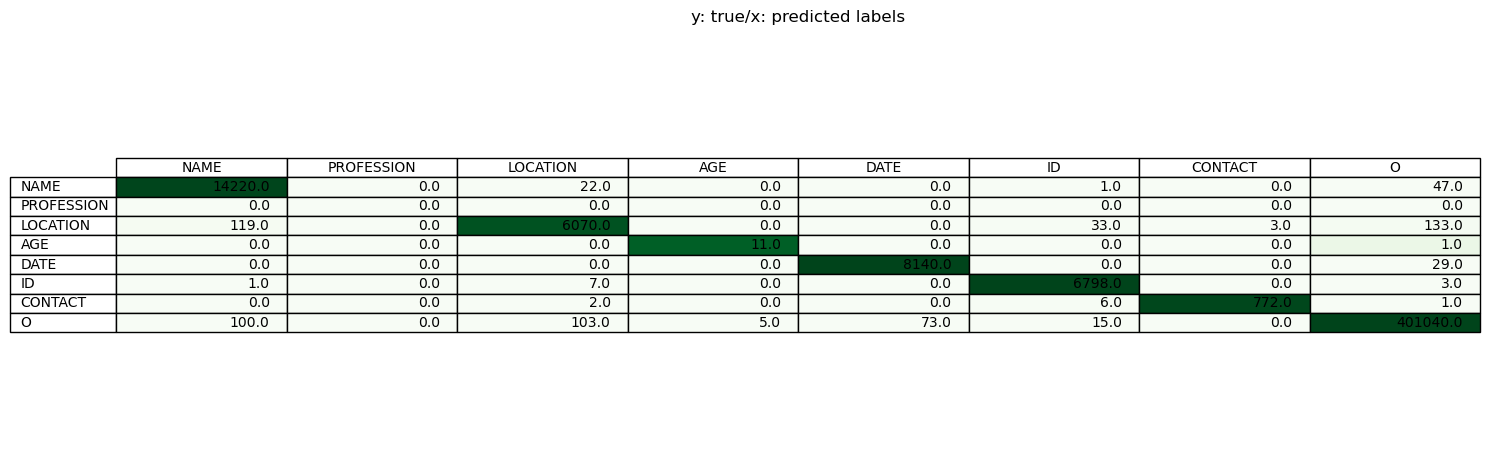

Wrongly predicted examples:
_____ Record 565:-29 _____
| Sentence:    | m | . | He | was | taken | to | the | Pre      | Health   | emergency | room | and | at | about | 2 | : | 45 | a | . | m | . | on | 7    | /    | 30   | an | electrocardiogram | demonstrated | 3 | to | 4 | mm | ST | elevations | in | leads | V1 | to | V4 | and | 2 | mm | ST | elevations | in | lead | V5 | . | He | was | treated | with | nitroglycerin | , | antacids | and | intravenous | morphine | . | He | was | transferred | to | Fairm    | of       | Ijordcompmac | Hospital | hemodynamically | stable | . | HE   | arrived | in | the |
| True labels: | O | O | O  | O   | O     | O  | O   | LOCATION | LOCATION | O         | O    | O   | O  | O     | O | O | O  | O | O | O | O | O  | DATE | DATE | DATE | O  | O                 | O            | O | O  | O | O  | O  | O          | O  | O     | O  | O  | O  | O   | O | O  | O  | O          | O  | O    | O  | O | O  | O   | O       | O    | O             | O | O        |

In [21]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

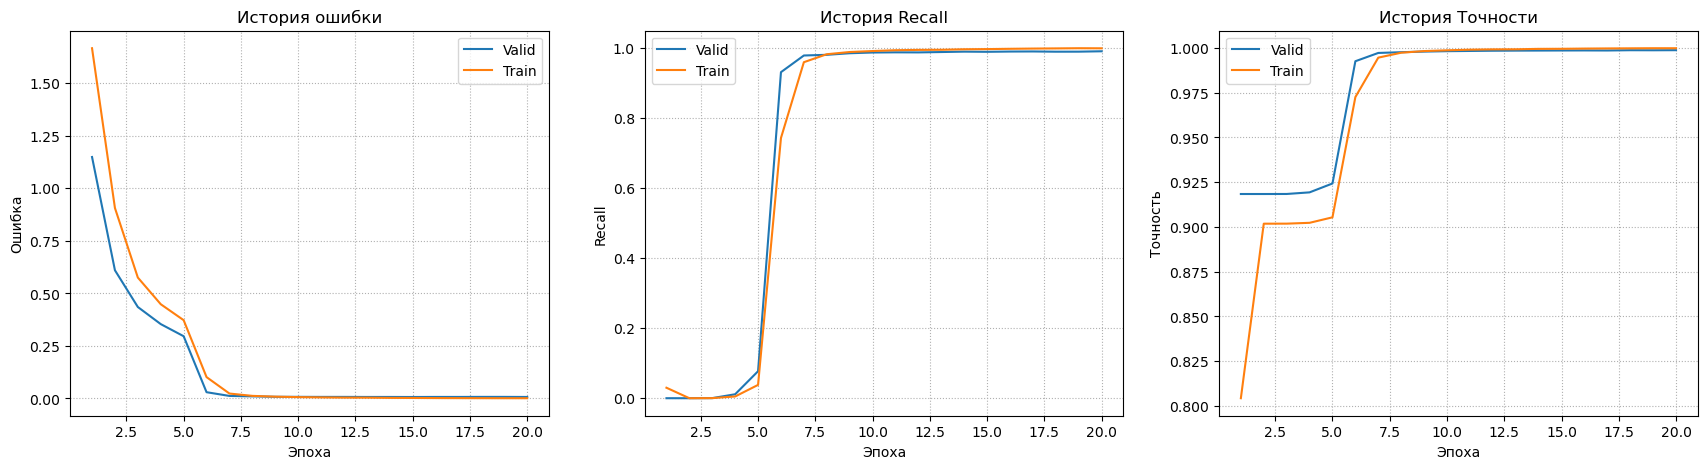

In [22]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(1)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [23]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2006_data_config['val_data_type'],
                               path_to_folder=i2b2_2006_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [24]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(1)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [25]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9987191557884216
     test_precision         0.9987191557884216
       test_recall          0.9901439547538757
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9901439547538757,
  'test_precision': 0.9987191557884216,
  'test_f1': 0.9987191557884216}]

              precision    recall  f1-score   support

        NAME     0.9909    0.9943    0.9926     10501
  PROFESSION     0.0000    0.0000    0.0000         0
    LOCATION     0.9872    0.9637    0.9753      5534
         AGE     1.0000    0.8000    0.8889        10
        DATE     0.9900    0.9977    0.9938      7821
          ID     0.9959    0.9976    0.9967      6264
     CONTACT     0.9833    0.9888    0.9860       714

   micro avg     0.9909    0.9901    0.9905     30844
   macro avg     0.8496    0.8203    0.8333     30844
weighted avg     0.9908    0.9901    0.9905     30844



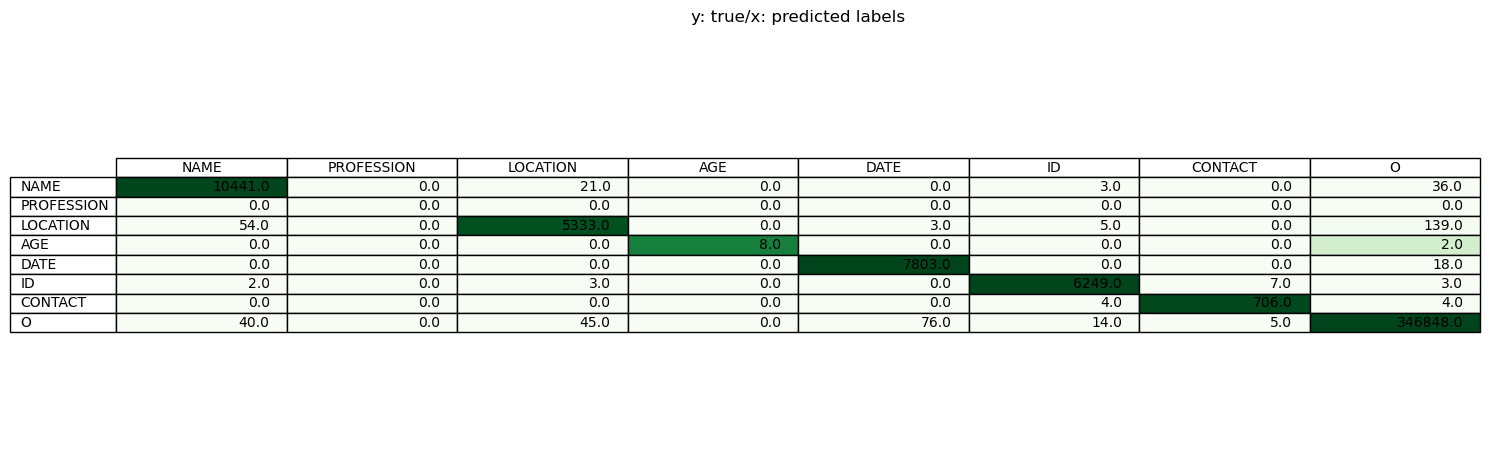

Wrongly predicted examples:
_____ Record 600:-7 _____
| Sentence:    | of       | ijordcompmac | hospital | emergency | ward | . | he | was | quite | paranoid | , | agitated | and | delusional | during | an | interview | and | there | is | no | evidence | to | support | the | patient | ' | s | history | and | recall | of | events | leading | to | the | hospitalization | . | hospital | course | by | system | . | 1 | . | neurologically | : | the | patient | is | completely | alert | , | awake | and | oriented | x | 3 | . | the | patient | shows | no | evidence | of | alcohol | withdrawal | although | he | was | prophylactically | treated | with | ativan | and | was | given | multivitamins | , | thiamine | and | folate |
| True labels: | LOCATION | LOCATION     | LOCATION | O         | O    | O | O  | O   | O     | O        | O | O        | O   | O          | O      | O  | O         | O   | O     | O  | O  | O        | O  | O       | O   | O       | O | O | O       | O   | O      | O  | O

In [26]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()